<span style="font-size:3em">How to predict with missing values in Python ?</span> 

**Aude Sportisse**

Missing values occur in many applications of supervised learning. Methods to deal with missing values in supervised learning are very different from methods to deal with missing values in a inferential framework. For instance mean imputation which is the worst thing that can be done when the aim is to estimate parameter can be consistent when the aim is to predict as well as possible, as shown in [this recent paper](https://arxiv.org/abs/1902.06931?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%253A+arxiv%252FQSXk+%2528ExcitingAds%2521+cs+updates+on+arXiv.org%2529). 

In this notebook, we will cover how to accurately predict the response `y` given `X` when `X` contains missing values (missing values in both training and testing data). 

In this case, there are essentially two approaches:
1. `Two-step strategy`: imputing missing data and applying classical methods on the completed data sets to predict;
2. `One-step strategy`: Predicting with methods adapted to the missing data without necessarily imputing them.
 
We first describe the methods on synthetic data and apply them on real datasets.

In [27]:
!pip install wget 

import numpy as np
import pandas as pd
import wget
import matplotlib.pyplot as plt
%matplotlib inline

wget.download('https://raw.githubusercontent.com/R-miss-tastic/website/master/static/how-to/python/produceNA.py')
wget.download('https://raw.githubusercontent.com/R-miss-tastic/website/master/static/how-to/python/tools.py')

from produceNA import *

from tools import color_imputedvalues_orange

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score

from sklearn.datasets import fetch_california_housing

import random

# Description of the different strategies

We generate the covariates $X$ with 3 variables from a Gaussian distribution with positive structure of correlation, the Gaussian noise $\epsilon$ from the standart Gaussian distribution and the fixed regression parameter $\beta$ with the uniform distribution. The outcome variable is obtained with the following linear model:
$$Y=X\beta+\epsilon.$$

In [2]:
np.random.seed(0)  # fix the seed 

n = 1000
d = 3

mean = np.repeat(0, d)
cov = 0.5 * (np.ones((d,d)) + np.eye(d))
x_comp = np.random.multivariate_normal(mean, cov, size = n)
b = np.random.uniform(low = 0, high = 3, size = d)
sigma_eps = 0.25
eps = np.random.normal(scale = sigma_eps, size = n)
y = x_comp.dot(b) + eps

We introduce some missing (here MCAR) values in the data matrix using the function `produce_NA` given in the Python Notebook [How to generate missing values in Python ?](https://rmisstastic.netlify.app/how-to/python/generate_html/how%20to%20generate%20missing%20values). 

In [3]:
p = 0.3 #30% of Missing Values

XproduceNA =  produce_NA(x_comp, p_miss=p, mecha="MCAR") #True for missing values, false for others
X_miss = XproduceNA['X_incomp']
x_miss = X_miss.numpy()
print('Ratio nan in X:', np.round(100 * np.sum(np.isnan(x_miss)) / x_miss.size,1), '%')

Ratio nan in X: 30.3 %


In [4]:
pd.DataFrame(x_miss).head().style.highlight_null(null_color='orange')

,0,1,2
0,-0.875268,-1.922959,-1.522801
1,-2.393913,-2.481345,-0.613787
2,-0.835337,-0.670269,-0.821626
3,0.504373,-0.827087,-0.683043
4,-0.365120,-0.810354,nan


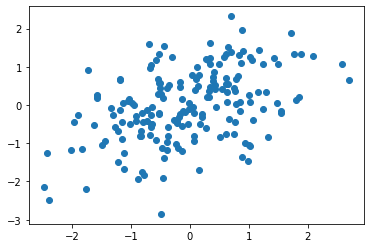

In [5]:
plt.scatter(x_miss[:400,0], x_miss[:400,1]);  #  data with missing coordinate are not plotted

## Two-steps strategy

We will consider two imputation methods:
* `Mean imputation`: replace missing values by the mean of the feature (the column);
* `Iterative imputation`: each feature is regressed/estimated from the others, which implies that imputation can take advantage of others features (it is the implementation proposed in [sklearn.impute.IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer))

More details on these methods can be found in [How to impute missing values in Python](https://rmisstastic.netlify.app/how-to/python/howtoimpute). 

Note that [Josse et al.](https://hal.archives-ouvertes.fr/hal-02024202v3/document) study the classic tools of missing values in the context of supervised learning. More particularly, they give the following take-home messages:

* If we possess a good learner algorithm and enough samples in our dataset (e.g. more than $10^5$), the mean imputation is a good default choice (since it is consistent). 
* It is important to use the same imputation for the train and the test set, since, in this case, the learning algorithm can learn the imputed value for detecting that the entry was initially missing.
* It might by fruitfull to add the missing values indicator (by concatenating the missing values indicator to `X`), in particular when missingness can be related to the prediction target (MNAR or MAR values).

In [6]:
## Mean imputation
x_mean = SimpleImputer().fit_transform(x_miss)
pd.DataFrame(x_mean).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2
0,-0.875268,-1.922959,-1.522801
1,-2.393913,-2.481345,-0.613787
2,-0.835337,-0.670269,-0.821626
3,0.504373,-0.827087,-0.683043
4,-0.365120,-0.810354,0.029433


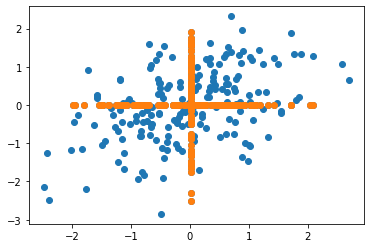

In [7]:
plt.scatter(x_mean[:400,0], x_mean[:400,1])

missing_mask = np.where([any(x) for x in np.isnan(x_miss[:400][:,[0,1]])])
plt.scatter(x_mean[missing_mask,0], x_mean[missing_mask,1])

To concatenate the missing indicator to `X`, we can use the argument `add_indicator=True` of SimpleImputer. Note that this concatenation is done after imputation and is only used for prediction.

In [8]:
## Mean imputation, return with indicator
x_mean_with_indicator = SimpleImputer(add_indicator=True).fit_transform(x_miss)
pd.DataFrame(x_mean_with_indicator).head().style.applymap(color_imputedvalues_orange, x_miss=np.concatenate((x_miss,np.isnan(x_miss)*1),axis=1))

,0,1,2,3,4,5
0,-0.875268,-1.922959,-1.522801,0.000000,0.000000,0.000000
1,-2.393913,-2.481345,-0.613787,0.000000,0.000000,0.000000
2,-0.835337,-0.670269,-0.821626,0.000000,0.000000,0.000000
3,0.504373,-0.827087,-0.683043,0.000000,0.000000,0.000000
4,-0.365120,-0.810354,0.029433,0.000000,0.000000,1.000000


In [9]:
# Iterative imputation
x_ice = IterativeImputer().fit_transform(x_miss)
pd.DataFrame(x_ice).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2
0,-0.875268,-1.922959,-1.522801
1,-2.393913,-2.481345,-0.613787
2,-0.835337,-0.670269,-0.821626
3,0.504373,-0.827087,-0.683043
4,-0.365120,-0.810354,-0.462637


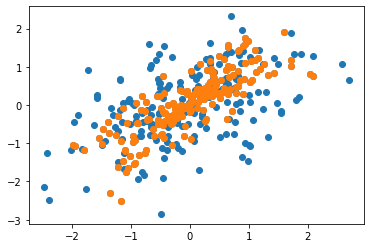

In [10]:
plt.scatter(x_ice[:400,0], x_ice[:400,1])

missing_mask = np.where([any(x) for x in np.isnan(x_miss[:400][:,[0,1]])])
plt.scatter(x_ice[missing_mask,0], x_ice[missing_mask,1])

In [11]:
## Iterative imputation, return with indicator
x_mice_with_indicator = IterativeImputer(add_indicator=True).fit_transform(x_miss)
pd.DataFrame(x_mice_with_indicator).head().style.applymap(color_imputedvalues_orange, x_miss=np.concatenate((x_miss,np.isnan(x_miss)*1),axis=1))

,0,1,2,3,4,5
0,-0.875268,-1.922959,-1.522801,0.000000,0.000000,0.000000
1,-2.393913,-2.481345,-0.613787,0.000000,0.000000,0.000000
2,-0.835337,-0.670269,-0.821626,0.000000,0.000000,0.000000
3,0.504373,-0.827087,-0.683043,0.000000,0.000000,0.000000
4,-0.365120,-0.810354,-0.462637,0.000000,0.000000,1.000000


## One-step strategy

We compare these imputations methods to a learning algorithm which can perform predictions by directly accounting for missing values:

* `Missing In Attribute Imputation (MIA)` [Twala et al.](https://www.sciencedirect.com/science/article/pii/S0167865508000305)): this method  is dedicated to handle missing values in tree based methods, such as randomforest, xgboost, etc... It is implimented in different packages (partykit  and grf in R and by default as imputation method in the function [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) from the module sklearn.ensemble of scikitlearn). If you want to implement it it by yourself, you can duplicate features twice and replace its missing values once by $\infty$ and once by $- \infty$ (or extreme out-of-range values).  Here, we choose to remplace them once by the maximum of the variable plus 1000 and once by the minimum of the variable minus 1000. More information on this method can be found in [Josse et al.](https://hal.archives-ouvertes.fr/hal-02024202v3/document).

This method does not pretend to impute missing data.  Here, the step of duplicating features is internal in the tree based learning algorithm.

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

class MinMaxImputer(BaseEstimator, TransformerMixin):
    # replacing the `nan` by two extremes values (by duplicating each column)
    
    def fit(self, X, y=None):
        mm = MinMaxScaler().fit(X)
        self.data_min_ = mm.data_min_
        self.data_max_ = mm.data_max_
        return self

    def transform(self, X):
        X_min, X_max = X.copy(), X.copy()

        for feature_idx in range(X.shape[1]):
            nan_mask = np.isnan(X[:, feature_idx])
            X_min[nan_mask, feature_idx] = self.data_min_[feature_idx] - 1
            X_max[nan_mask, feature_idx] = self.data_max_[feature_idx] + 1

        return np.concatenate([X_min, X_max], axis=1)

In [13]:
x_MIA = MinMaxImputer().fit_transform(x_miss)

In [14]:
pd.DataFrame(x_MIA).head().style.applymap(color_imputedvalues_orange, x_miss=np.concatenate((x_miss,np.isnan(x_miss)*1),axis=1))

,0,1,2,3,4,5
0,-0.875268,-1.922959,-1.522801,-0.875268,-1.922959,-1.522801
1,-2.393913,-2.481345,-0.613787,-2.393913,-2.481345,-0.613787
2,-0.835337,-0.670269,-0.821626,-0.835337,-0.670269,-0.821626
3,0.504373,-0.827087,-0.683043,0.504373,-0.827087,-0.683043
4,-0.365120,-0.810354,-4.032794,-0.365120,-0.810354,4.013304


## Pipeline

Let's evaluate the different strategies. Let's consider our different imputers w.r.t. different machine learning algorithms. The pipeline will be 
1. Imputation.
2. Regression on the imputed dataset.

Here we decompose each step of the pipeline for clarity.

First, we can split the data intro train and test datasets. 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_miss, y)
print('train shape: X.shape={}, y.shape={}'.format(x_train.shape, y_train.shape))
print('test shape: X.shape={}, y.shape={}'.format(x_test.shape, y_test.shape))

train shape: X.shape=(750, 3), y.shape=(750,)
test shape: X.shape=(250, 3), y.shape=(250,)


We can then choose a learning algorithm, for exemple the random forests. We can use the class [sklearn.linear_model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) of scikit-learn. Note that we can not directly apply the learner, since it can not deal with missing values. 

In [16]:
learner = RandomForestRegressor()

In [17]:
""" Line below would raise an ValueError: 
'Input contains NaN, infinity or a value too large for dtype('float64').'
Because LinearRegressor couldn't deal with NaN values.""";

# learner.fit(X_train, y_train) 

We fit the model for imputing missing values in the train dataset and then transform both train and test with the *same* imputer.

In [18]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(x_train)

x_train_imp = imputer.transform(x_train)
x_test_imp = imputer.transform(x_test)

Finally, we can fit the learner. 

In [19]:
learner.fit(x_train_imp, y_train)
print('Score on train:', learner.score(x_train_imp, y_train))
print('Score on test:', learner.score(x_test_imp, y_test))

Score on train: 0.9559328366636736
Score on test: 0.8036095091168469


# Method selection on synthetic data

The function **score_pred** compares the strategies above for synthetic data in terms of prediction performances by applying chosen learning algorithms. 

More precisely, the function takes as imput a complete data matrix (`X`) and an output variable (`y`). Then, missing values are introduced in the complete data matrix with both specific percentage of missing values (`p`) and missing-data mechanism (`mecha`). Each method is performed with a learning algorithm (`learner`). The methods are detailed below:
* Mean imputation with or without adding the mask + Learning algorithm (two-step method), 
* Iterative imputation with or without adding the mask + Learning algorithm (two-step method), 
* Learning algorithm if the learning algorithm account for MIA (one-step method, if `opt_learner="Learner_MIA"`) or MIA + Learning algorithm otherwise.

The introduction of the missing values is done several times (`nbsim`), it implies the stochasticity in the results (and boxplots).

The arguments are the following.

* `X`: complete data matrix (covariates).
* `y`: output variable.
* `learner`: learner to be performed for comparing strategies (e.g. random forests, gradient boosting, linear regression).
* `p` : percentage of missing values to introduce.
* `nbsim` : number of simulations performed.
* `opt_learner`: indicates if the learning algorithm account for MIA (`opt_learn="Learner_MIA"`).
* `mecha` : missing-data mechanism to use for introducing the missing values.

It returns scores for each strategy. 

In [21]:
def score_pred(X, y, learner, p, nbsim, opt_learner = "Learner_MIA", mecha = "MCAR"):
    """
    Compare imputation methods (Mean imputation and Iterative imputation, with or without concatenating missing values indicator) 
    with the Missing In Attribute method in terms of prediction performance for chosen learning algorithms.
    
    
    Parameters
    ----------
    X : complete data matrix (covariates).
    y : output variable.
    learner : dictionnary containing the learners to be performed for comparing strategies (e.g. random forests, linear regression).
    learner_name : names of the learners.
    p : percentage of missing values to introduce.
    mecha : missing-data mechanism to use for introducing the missing values. 
    
    Returns
    -------
    Scores for each strategy. 
    """
    
    score_results = pd.DataFrame()
    Methods = ['Mean','Iterative','Mean + Mask','Iterative + Mask','MIA']
    for meth in Methods:
        score_results[meth]=[]
    
    for sim in range(0,nbsim):
        if mecha == 'MCAR':
            XproduceNA =  produce_NA(x_comp, p_miss=p, mecha=mecha) 
            x_miss = XproduceNA['X_incomp'].numpy()
        else:
            XproduceNA =  produce_NA(x_comp, p_miss=p, mecha=mecha, opt="logistic", p_obs=0.5) 
            x_miss = XproduceNA['X_incomp'].numpy()

        x_train, x_test, y_train, y_test = train_test_split(x_miss, y)

        #### Mean imputation without mask + learner
        mean_imputer = SimpleImputer(add_indicator=False)
        mean_imputer.fit(x_train)
        x_train_imp = mean_imputer.transform(x_train)
        x_test_imp = mean_imputer.transform(x_test)
        learner.fit(x_train_imp, y_train)
        score_mean = learner.score(x_test_imp, y_test)

        #### Iterative imputation without mask + learner
        it_imputer = IterativeImputer(add_indicator=False)
        it_imputer.fit(x_train)
        x_train_imp = it_imputer.transform(x_train)
        x_test_imp = it_imputer.transform(x_test)
        learner.fit(x_train_imp, y_train)
        score_it = learner.score(x_test_imp, y_test)

        #### Mean imputation with mask + learner
        mean_wh_imputer = SimpleImputer(add_indicator=False)
        mean_wh_imputer.fit(x_train)
        x_train_imp = mean_wh_imputer.transform(x_train)
        x_test_imp = mean_wh_imputer.transform(x_test)
        learner.fit(x_train_imp, y_train)
        score_mean_wh = learner.score(x_test_imp, y_test)

        #### Iterative imputation with mask + learner
        it_wh_imputer = IterativeImputer(add_indicator=False)
        it_wh_imputer.fit(x_train)
        x_train_imp = it_wh_imputer.transform(x_train)
        x_test_imp = it_wh_imputer.transform(x_test)
        learner.fit(x_train_imp, y_train)
        score_it_wh = learner.score(x_test_imp, y_test)

        #### MIA
        if opt_learner == 'Learner_MIA':
            learner.fit(x_train,y_train)
            score_MIA = learner.score(x_test, y_test)
        else: 
            MIA_imputer = MinMaxImputer()
            x_train_imp = MIA_imputer.fit_transform(x_train)
            x_test_imp = MIA_imputer.transform(x_test)
            learner.fit(x_train_imp, y_train)
            score_MIA = learner.score(x_test_imp, y_test)
        
        new_score = {'Mean': score_mean, 'Iterative': score_it, 'Mean + Mask': score_mean_wh, 'Iterative + Mask': score_it_wh, 'MIA': score_MIA}
        score_results = score_results.append(new_score, ignore_index=True)

        
    return(score_results)

We apply this function by introducing MCAR or MNAR values in `X`. MCAR means that the probability that an observation is missing is independent of the data. MNAR means that the missingness depends on the missing values and potentially also on the observed values. To introduce missing values, we use [How to generate missing values](https://rmisstastic.netlify.app/how-to/python/generate_html/how%20to%20generate%20missing%20values).

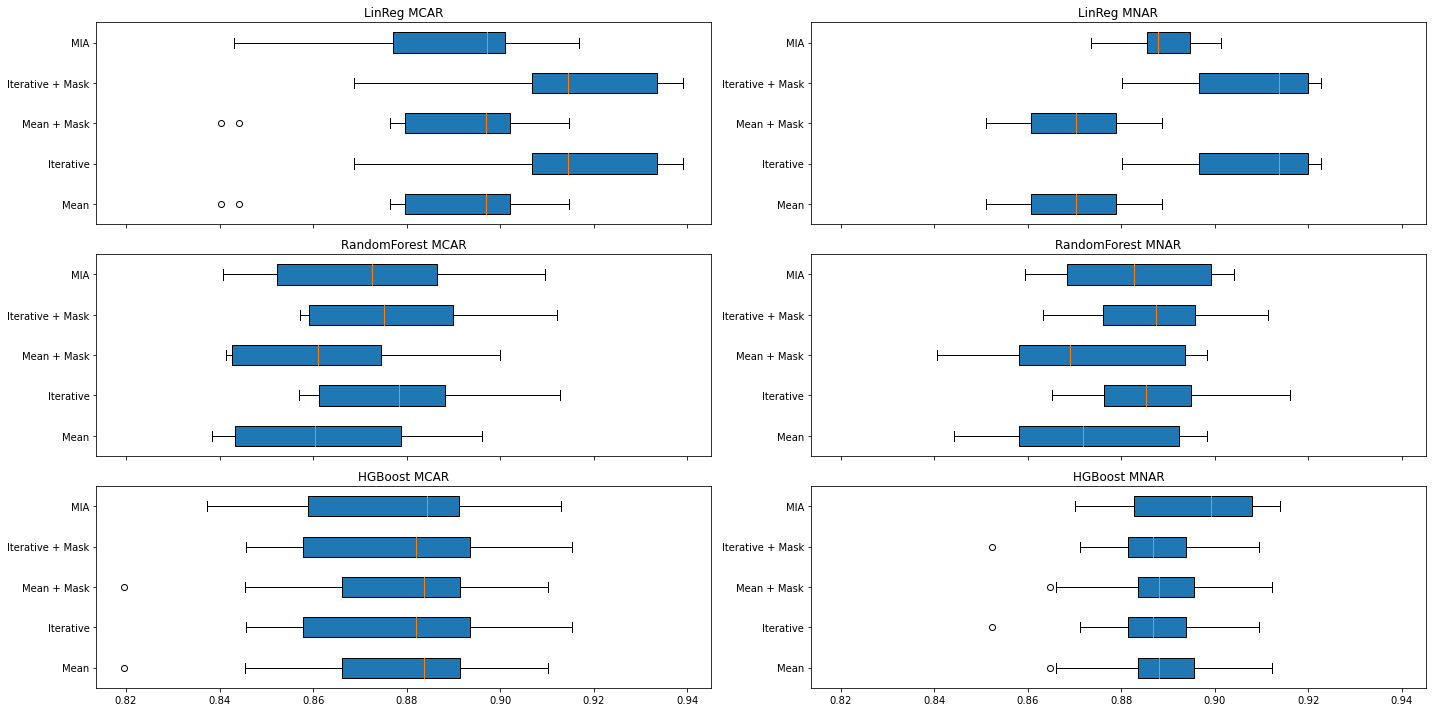

In [22]:
learners = {'LinReg': LinearRegression(),
              'RandomForest': RandomForestRegressor(),
              'HGBoost': HistGradientBoostingRegressor()}
p = 0.2
nbsim = 10

fig, ax = plt.subplots(3,2,figsize=(20,10),sharex=True)
for ind_l, (learner_name, learner) in enumerate(learners.items()):
    for ind_m, mecha in enumerate(['MCAR', 'MNAR']):
        if learner_name=='HGBoost':
            opt_learner="Learner_MIA"
        else:
            opt_learner="Learner_MIA_not"
        res=score_pred(x_comp, y, learner, p, nbsim=nbsim, opt_learner = opt_learner, mecha = mecha)
        labels = res.columns
        ax[ind_l,ind_m].set_title(learner_name+" "+mecha)  
        ax[ind_l,ind_m].boxplot(res, labels=labels, vert=False, patch_artist=True)
fig.tight_layout()

# Method selection on real data

The function **plot_score_realdatasets** can be used for real datasets containing missing values. The arguments are the following.

* `X`: data matrix containing missing values (covariates).
* `y`: output variable (containing no missing values)y: output variable (containing no missing values).
* `learner`: dictionnary containing the learners to be performed for comparing strategies.

It returns Boxplot scores for each method (Mean imputation, Iterative imputation, MIA), the stochasticity comes from the way to split the dataset into a train set and a test set which is repeated several times.

In [23]:
def plot_score_realdatasets(X, y, learner, learner_name='learner', X_complete=None, cv=5):
    """
    Compare imputation methods (Mean imputation and Iterative imputation, with or without concatenating missing values indicator) 
    with the Missing In Attribute method in terms of prediction performance for chosen learning algorithms.
    
    
    Parameters
    ----------
    X : data matrix containing missing values.
    y : output variable (containing no missing values).
    learner: dictionnary containing the learners to be performed for comparing strategies.
    learner_name: name for the learners containing in learner.
    X_complete: complete data matrix (None if the dataset contains real missing values).
    cv: number of folds in the stratified folds.
    
    Returns
    -------
    Boxplot scores for each strategy.
    """
    
    imputers_wo_indicator = {'Mean': SimpleImputer(add_indicator=False),
                         'Iterative': IterativeImputer(add_indicator=False)}
    imputers_with_indicator = {'Mean': SimpleImputer(add_indicator=True),
                           'Iterative': IterativeImputer(add_indicator=True),
                           'MinMax': MinMaxImputer()}
    
    l_score = []
    for imputers in [imputers_wo_indicator, imputers_with_indicator]:
        for imputer_name, imputer in imputers.items():
            pipeline = Pipeline([(imputer_name, imputer), (learner_name, learner)])
            score = cross_val_score(pipeline, X, y, n_jobs=-1, cv = cv)
            l_score.append(score)
            
    score_ground_truth = cross_val_score(learner, X_complete, y, n_jobs=-1, cv = cv)
    l_score.append(score_ground_truth)
    plt.title(learner_name)     
    labels = ['Mean', 'Iterative', 'Mean+Mask', 'Iterative+Mask', 'MIA', 'X_complete']
    bplot = plt.boxplot(l_score[::-1], labels=labels[::-1],
                vert=False, patch_artist=True)

    # Add colors to boxplots
    #for patch, color in zip(bplot['boxes'],
                            #['C0','C1','C2','C3', 'C4', 'C5']):
        #patch.set_facecolor(color)

Here, we study a real dataset which does not contain real missing values, thus we add some missing values (MCAR or MNAR) before applying the function **plot_score_realdatasets**. In this case, we can compute the scores for the complete matrix, which are represented in the boxplots.

In [24]:
x_comp, y = fetch_california_housing(return_X_y = True)

In [25]:
p=0.2
## MCAR values
XproduceNA_MCAR =  produce_NA(x_comp, p_miss=p, mecha="MCAR") 
x_MCAR = XproduceNA_MCAR['X_incomp'].numpy()
print('Ratio nan in X:', np.round(100 * np.sum(np.isnan(x_MCAR)) / x_MCAR.size,1), '%')
# MNAR values
XproduceNA_MNAR = produce_NA(x_comp, p_miss=p, mecha="MNAR", opt="logistic", p_obs=0.5)
x_MNAR = XproduceNA_MNAR['X_incomp'].numpy()
print('Ratio nan in X:', np.round(100 * np.sum(np.isnan(x_MNAR)) / x_MNAR.size,1), '%')

Ratio nan in X: 20.0 %
Ratio nan in X: 19.9 %


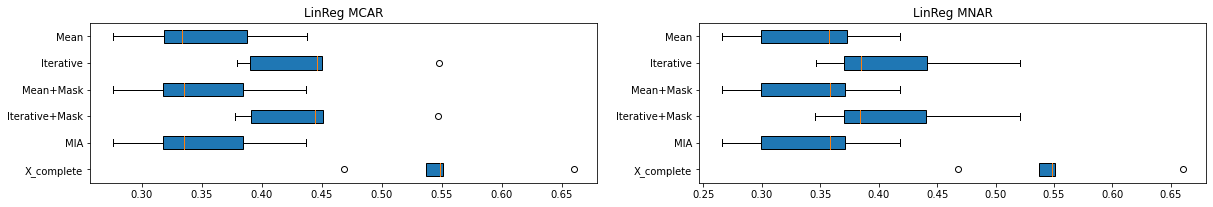

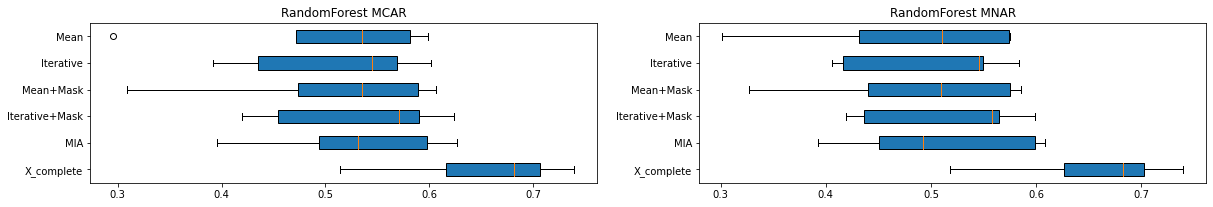

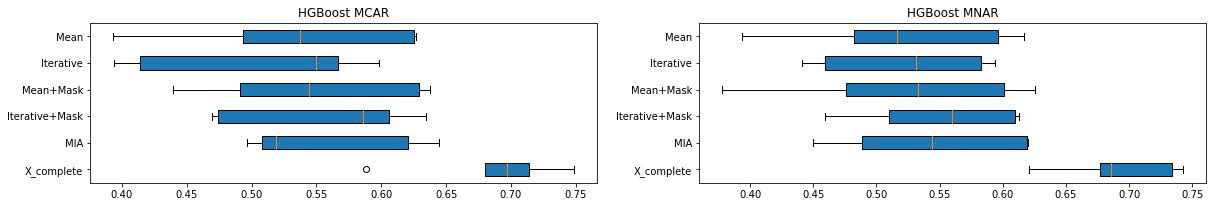

In [28]:
learners = {'LinReg': LinearRegression(),
              'RandomForest': RandomForestRegressor(),
              "HGBoost": HistGradientBoostingRegressor()}

for learner_name, learner in learners.items():
    plt.figure(figsize=(20,10))
    for ii, (X, X_name) in enumerate(zip([x_MCAR, x_MNAR], ['MCAR', 'MNAR'])):
        plt.subplot(3, 2, ii+1)
        plot_score_realdatasets(X, y, learner, learner_name + ' ' + X_name, x_comp)